# Import Library yang diperlukan

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as stopwords_scratch
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import emoji

# Mengimport model yang sudah dilatih sebelumnya

In [2]:
feature_bow = pickle.load(open("./model/feature-bow.p",'rb'))
model_nb = pickle.load(open('./model/model-nb.p', 'rb'))
model_nn = pickle.load(open('./model/model-nn.p', 'rb'))

d:\Kuliah\Semester 5\Aplikasi Web\Praktikum 9\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Kuliah\Semester 5\Aplikasi Web\Praktikum 9\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Kuliah\Semester 5\Aplikasi Web\Praktikum 9\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle es

# Menginisialisasi stopwords lalu menyimpan ke bentuk csv

In [3]:
# Panggil stopword ID
list_stopwords = stopwords_scratch.words('indonesian')
# Panggil stopword EN
list_stopwords_en = stopwords_scratch.words('english')
# Gabungkan ID & EN
list_stopwords.extend(list_stopwords_en)
# Tambah daftar stopword jika perlu
list_stopwords.extend(['ya', 'yg', 'ga', 'yuk', 'dah', 'ngga', 'engga', 'ygy', 'gak', 'nya'])

In [4]:
# Buat DataFrame dari list stopwords
stopwords_df = pd.DataFrame(list_stopwords, columns=['stopword'])

# Simpan DataFrame sebagai CSV
stopwords_df.to_csv('./data/stopwords.csv', index=False, header=False)

# Mengimport dataset 

In [6]:
df = pd.read_csv('./data/comments.csv')
stopword = pd.read_csv('./data/stopwords.csv', header=None)

# Menginisialiasi Stemmer untuk bahasa Indonesia (mengubah kata ke bentuk dasar)

In [7]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Membuat method pre processing text untuk membersihkan dataset dari emoji, karakter khusus, membuat jadi lower case

In [8]:
def preprocess_text(text):
    # Hapus emoji
    text = emoji.replace_emoji(text, replace="") 
    # Hapus nama orang (jika ada pola umum, misalnya kapitalisasi atau nama-nama tertentu)
    text = re.sub(r'\b[A-Z][a-z]*\b', '', text)
    # Hapus karakter khusus, angka, dan URL
    text = re.sub(r'http\S+|www\S+|https\S+|[^a-zA-Z\s]', '', text)
    # Konversi ke lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopword]
    # Remove very short words (less than 2 characters)
    tokens = [word for word in tokens if len(word) > 2]
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back to a single string
    return ' '.join(tokens)

# Menerapkan method preprocess_text ke dalam df pada kolom 'comment' yang disimpan menjadi kolom 'cleaned_comment'

In [9]:
df['cleaned_comment'] = df['comment'].apply(preprocess_text)

# Tampilkan hasil pre-processing pada beberapa baris pertama
print(df[['comment', 'cleaned_comment']].head())

                   comment cleaned_comment
0                    30:03                
1                    55:43                
2                  1:34:55                
3                    28:48                
4  Gibraaaann MANTAPKU🔥🔥🔥🔥          mantap


# Menghapus string kosong pada kolom 'cleaned_comment'

In [10]:
df = df[df['cleaned_comment'].str.strip() != '']

# Menyimpan data yang telah dibersihkan ke ekstensi file csv dengan nama 'cleaned_comments.csv'

In [11]:
df.to_csv('./data/cleaned_comments.csv', index=False)

# Mengimport data 'cleaned_comments' 

In [12]:
data_cleaned = pd.read_csv('./data/cleaned_comments.csv')
data_cleaned.head()

,comment,cleaned_comment
0,Gibraaaann MANTAPKU🔥🔥🔥🔥,mantap
1,Pengen balik ke sini. Lihat orang2 yg dulu ng...,balik sini orang dulu ngalem bocil msh teguh d...
2,Woi Tapera Tapera ok gas ok gas pretttt,gas gas pretttt
3,AkademisiRocky Gerung,akademisirocky
4,uustadzRockyvGerungprofDrAhliFilsapatnterkemuk...,uustadzrockyvgerungprofdrahlifilsapatnterkemukadi


# Membuat method bernama predict_sentiment untuk memprediksi sentimen per baris dari dataset

In [13]:
def predict_sentiment(sent):
    text=str(sent)
    # feature extraction
    text_feature = feature_bow.transform([text])
    # predict
    return model_nb.predict(text_feature)[0]

# Menerapkan method predict_sentiment ke dalam df pada kolom 'cleaned_comment' yang disimpan menjadi kolom 'predicted_sentiment'

In [14]:
data_cleaned['predicted_sentiment'] = data_cleaned.cleaned_comment.apply(predict_sentiment)

data_cleaned.head()

,comment,cleaned_comment,predicted_sentiment
0,Gibraaaann MANTAPKU🔥🔥🔥🔥,mantap,positive
1,Pengen balik ke sini. Lihat orang2 yg dulu ng...,balik sini orang dulu ngalem bocil msh teguh d...,negative
2,Woi Tapera Tapera ok gas ok gas pretttt,gas gas pretttt,positive
3,AkademisiRocky Gerung,akademisirocky,positive
4,uustadzRockyvGerungprofDrAhliFilsapatnterkemuk...,uustadzrockyvgerungprofdrahlifilsapatnterkemukadi,positive


# Menyimpan data yang telah dibersihkan ke ekstensi file csv dengan nama 'predicted_sentiment.csv'

In [15]:
data_cleaned.to_csv('./data/predicted_sentiment.csv', index=False)

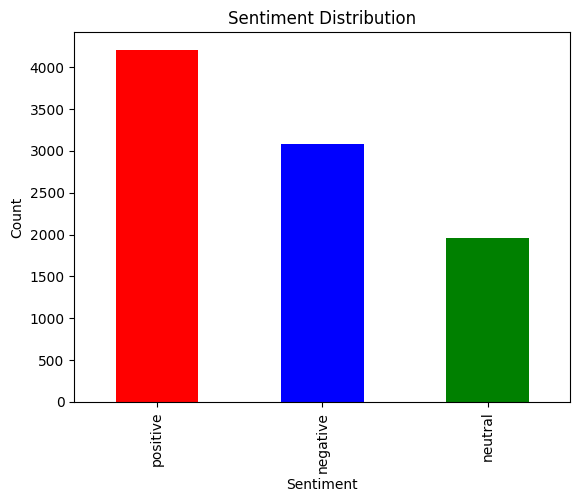

In [2]:
df = pd.read_csv('./data/predicted_sentiment.csv')

sentiment_counts = df['predicted_sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [3]:
min_count = sentiment_counts.min()

# Sample the minimum count of each sentiment
df_balanced = df.groupby('predicted_sentiment').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

print(df_balanced['predicted_sentiment'].value_counts())

predicted_sentiment
negative    1962
neutral     1962
positive    1962
Name: count, dtype: int64


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_147240\1667129359.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('predicted_sentiment').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [5]:
df_balanced.to_csv('./data/predicted_sentiment_balanced.csv', index=False)